In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
connecting_words = ['and', 'or', 'but', 'for', 'nor', 'so', 'yet', 'after', 'although', 'as', 'because', 'before', 'if', 'once', 'since', 'though', 'unless', 'until', 'when', 'where', 'while', 'that', 'which', 'who', 'whom', 'whose', 'what', 'whose', 'how', 'why','on']
articles = ['a', 'an', 'the']

In [ ]:
with open('data.json') as content:
  data1 = json.load(content)

In [ ]:
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['inputs']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [ ]:
data = pd.DataFrame({"inputs": inputs, "tags" : tags})

In [ ]:
data

,inputs,tags
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Heya,greeting
...,...,...
290,how to unfollow.,unfollow_someone_insta
291,process of unfollowing,unfollow_someone_insta
292,unfollow,unfollow_someone_insta
293,unfollow someone,unfollow_someone_insta


In [ ]:
import string
data['inputs'] = data['inputs'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd:''. join(wrd))

def replace_connecting_words(sentence):
    words = sentence.split()
    words = [word for word in words if word.lower() not in connecting_words and word.lower() not in articles]
    return ' '.join(words)

data['inputs'] = data['inputs'].apply(replace_connecting_words)
data['inputs']

0                            hi
1                       are you
2               is anyone there
3                         hello
4                          heya
                 ...           
290                 to unfollow
291      process of unfollowing
292                    unfollow
293            unfollow someone
294    want to unfollow someone
Name: inputs, Length: 295, dtype: object

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

from tensorflow. keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [ ]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
input_shape = x_train.shape[1]
print(input_shape)

7


In [ ]:
vocabulary = len(tokenizer.word_index)
print("number of unique words: ", vocabulary)

output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words:  204
output length:  29


In [ ]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary + 1, 10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model = Model(i, x)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=350, validation_data=(x_test, y_test))

Epoch 1/350
8/8 [==============================] - 4s 103ms/step - loss: 3.3674 - accuracy: 0.0297 - val_loss: 3.3666 - val_accuracy: 0.0678
Epoch 2/350
8/8 [==============================] - 0s 13ms/step - loss: 3.3641 - accuracy: 0.0508 - val_loss: 3.3655 - val_accuracy: 0.0508
Epoch 3/350
8/8 [==============================] - 0s 13ms/step - loss: 3.3613 - accuracy: 0.0805 - val_loss: 3.3644 - val_accuracy: 0.0847
Epoch 4/350
8/8 [==============================] - 0s 14ms/step - loss: 3.3583 - accuracy: 0.1271 - val_loss: 3.3629 - val_accuracy: 0.1356
Epoch 5/350
8/8 [==============================] - 0s 11ms/step - loss: 3.3548 - accuracy: 0.1356 - val_loss: 3.3611 - val_accuracy: 0.1186
Epoch 6/350
8/8 [==============================] - 0s 11ms/step - loss: 3.3505 - accuracy: 0.1441 - val_loss: 3.3589 - val_accuracy: 0.1186
Epoch 7/350
8/8 [==============================] - 0s 11ms/step - loss: 3.3452 - accuracy: 0.1314 - val_loss: 3.3562 - val_accuracy: 0.1356
Epoch 8/350
8/8 [==

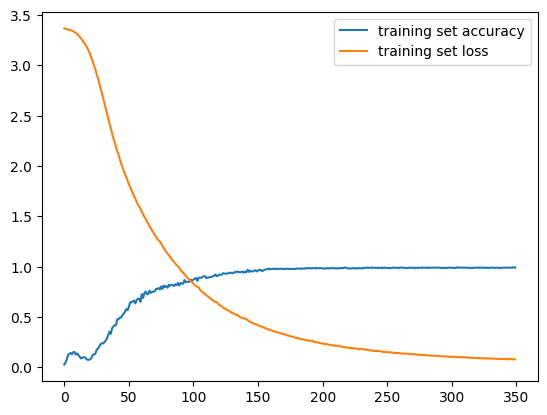

In [ ]:
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['loss'], label='training set loss')
plt.legend()
plt.show()

In [ ]:
import random

def predict_response(prediction_input):

    words = prediction_input.split()
    words = [word for word in words if word.lower() not in connecting_words and word.lower() not in articles]
    prediction_input = ' '.join(words)
    texts_p = [prediction_input]

    # Tokenize and pad
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    # Get output from model
    output = model.predict(prediction_input)
    output = output.argmax()
    print(output)
    # Finding the right tag and predicting
    response_tag = le.inverse_transform([output])[0]
    return random.choice(responses[response_tag])


In [ ]:
!pip install gradio
import gradio as gr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.0 MB/s et

In [ ]:
iface = gr.Interface(fn=predict_response,inputs="text",outputs="text")
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://aea5711c7c09b90a8d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
# Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

2/2 [==============================] - 4s 12ms/step
Accuracy: 0.576271186440678
Precision: 0.7001614205004035
Recall: 0.576271186440678
F1 Score: 0.556983019196379
Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0